# TUTORIAL: fem_toolbox 1D case 

---

**This notebook makes ideal use of the package and all its functionality for a 1D structure (single beams), bringing the user through the ideal FEA workflow. It can therefore be seen as a tutorial and used as reference for other cases.**

**This notebook shows how to use the fem_toolbox package to pre-process, solve and post-process 1D problems. For this first tutorial only, a thorough explanation of the interface of almost every fuction is provided (have a look at fem_2D_tutorial.ipynb if you search for a "quick-guide" instead).**

---

In [1]:
import fem_toolbox as ft

  __                _              _ _               
 / _|              | |            | | |              
| |_ ___ _ __ ___  | |_ ___   ___ | | |__   _____  __
|  _/ _ \ '_ ` _ \ | __/ _ \ / _ \| | '_ \ / _ \ \/ /
| ||  __/ | | | | || || (_) | (_) | | |_) | (_) >  < 
|_| \___|_| |_| |_| \__\___/ \___/|_|_.__/ \___/_/\_\
                ______                               
               |______|                              

github.com/Gabbbri/fem_toolbox


## Preprocessing

### Importing geometry

First step is importing the geometry from an external txt file. We will use the function 
```python
read_structure("file_path")
```

---



**Input file structure:**

The first line should define material properties: E rho 0 0 0 0.
Each subsequent line defines a single beam as: x1 y1 x2 y2 A I.

**Returns**

- node_coords_beam (ndarray, shape (N, 2)): 
Unique coordinates of all nodes (2D).

- connectivity_beam (ndarray, shape (E, 2)): 
Element-to-node connectivity (index pairs referencing node_coords_beam).

- beam_crossSections (list of dict): 
List of dictionaries with cross-sectional data for each beam:
    -  "A": Area
    -  "I": Moment of inertia

- mat_properties (dict): 
Material properties:
    - "E": Young's modulus
    - "rho": Density



In [2]:
# reading geometry
nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = ft.geometry.read_structure("../Tutorials/geometry&boundary-files/mybeam.txt")


### Meshing

We will now perform the conversion of a high-level frame geometry into a finite element mesh by discretizing beams into smaller elements, using the function
```python
discretize(node_coords_beam, beam_connectivity, beam_crossSsections, elements_per_beam=5, strategy="uniform")
```
---


**Function parameters:**

- node_coords_beam (ndarray, shape (N, 2)):
Coordinates of the input geometry’s nodes.

- beam_connectivity (ndarray, shape (B, 2)):
Node indices defining each beam.

- beam_sections (list of dicts):
Cross-section properties for each beam ({"A": ..., "I": ...}).

- elements_per_beam (int, default=5):
Number of FEM elements to create per beam.

- strategy (str, default="uniform"):
Currently only "uniform" subdivision is supported.

**Returns:**

- fem_nodes (ndarray, shape (M, 2)):
Unique coordinates of the generated FEM nodes.

- fem_elements (ndarray, shape (E, 2)):
Element connectivity using node indices.

- element_crossSection (list of dicts):
Cross-section properties for each FEM element.

In [3]:
# meshing
elements_per_beam = 5

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=elements_per_beam)

### Visual check: geometry and mesh visualization

We want to visualize both the original beam geometry and the corresponding discretized FEM mesh, using the function
```python
plot_discretized_geometry(original_nodes, original_beams, fem_nodes, fem_elements, show_elements=True, show_nodes=True, node_label_offset=0.02)
```

---

**Function parameters**

- original_nodes (ndarray, shape (N, 2)):
Coordinates of the original geometry nodes.

- original_beams (ndarray, shape (B, 2)):
Beam connectivity as pairs of node indices.

- fem_nodes (ndarray, shape (M, 2)):
Coordinates of the FEM nodes created through discretization.

- fem_elements (ndarray, shape (E, 2)):
FEM element connectivity using FEM node indices.

- show_elements (bool, default=True):
If True, labels each FEM element with its index at the midpoint.

- show_nodes (bool, default=True):
If True, labels each FEM node with its index.

- node_label_offset (float, default=0.02):
Offset used to avoid overlapping node labels with node markers.

**Returns:**

- (None):
Generates and displays a matplotlib plot showing the discretized geometry, original beam lines, and optional node/element IDs.

**Note:**
The function works best for 2D frames



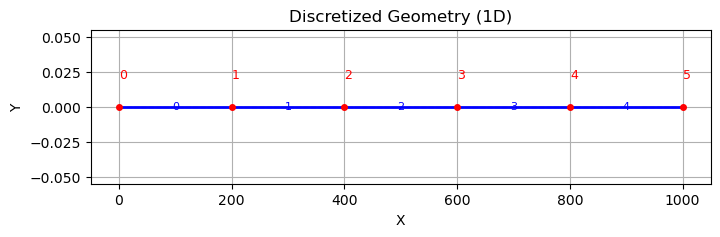

In [4]:
# geometry and mesh visualization
ft.mesh.plot_discretized_geometry_1D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

### Reading boundary conditions and external forces


We will read BC and external forces from a txt file, employing the function
```python
read_bc_and_forces('file_path')
```

---


**Function parameters:**

- file_path (str): 
Path to the BC/force input file.

    - BC lines start with "BC node_id" followed by (dof value) pairs, e.g., BC 3 (0 0.0) (1 0.0).

    - Force lines start with "FORCE node_id dof value", e.g., FORCE 2 1 -500.

**Returns:**

- constrained_nodes (list[int]): 
Sorted unique nodes with BCs.

- bc_nodes (list[int]): 
Nodes where BCs are applied (may contain duplicates).

- bc_dofs (list[int]): 
Degrees of freedom constrained (0=u, 1=v, 2=theta).

- bc_values (list[float]): 
Values prescribed at constrained DOFs.

- f_nodes (list[int]): 
Nodes with applied forces.

- f_dofs (list[int]): 
DOFs where forces are applied.

- f_values (list[float]): 
Force values.

In [5]:
# read BC and forces
_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../Tutorials/geometry&boundary-files/1D_bc_forces.txt")

# validate constraints (read docs)
num_nodes= fem_nodes.shape[0]
num_dofs = 2   # using normal beam elements
ft.BC_loads.validate_constraints(num_nodes, num_dofs, bc_nodes, bc_dofs)

Constraint check passed: 2 DOFs constrained out of 12.


### Visual validation of the setup

Before solving, it is useful to visual check the setup, to make sure that the inputs from file are correct and the problem is setted correctly. To do so, we will use the function
```python
plot_fem_model(node_coords, fem_elements, bc_nodes, bc_dofs, bc_vals, force_nodes, force_dofs, force_vals, scale_force=0.1, scale_moment=0.1)
```

---

**Function parameters:**

- node_coords (ndarray, shape (N, 2)): 
Coordinates of FEM nodes.

- fem_elements (ndarray, shape (E, 2)): 
Connectivity of FEM elements.

- bc_nodes (list[int]): 
Nodes with BCs.

- bc_dofs (list[int]): 
DOFs constrained.

- bc_vals (list[float]): 
Values of BCs.

- force_nodes (list[int]): 
Nodes with forces.

- force_dofs (list[int]): 
DOFs with applied forces.

- force_vals (list[float]): 
Force magnitudes.

- scale_force (float, default=0.1): 
Scaling factor for force arrow length.

- scale_moment (float, default=0.1): 
Scaling factor for moment visualization.

**Returns:**

- (None): Displays a matplotlib plot with:

    - FEM elements (black lines).

    - Nodes (red dots with blue labels).

    - BCs as colored squares (blue, green, magenta).

    - Forces as arrows or moment arcs.


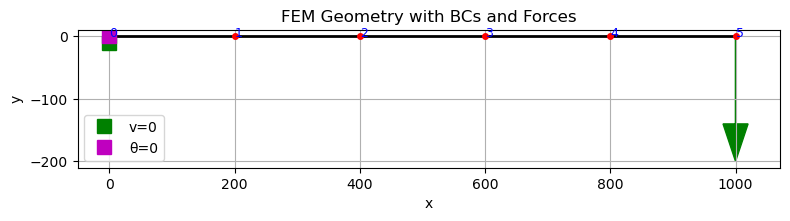

In [6]:
# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.2)

## FEA

### Assembling global stiffness and mass matrices

To assemble the matrices we will make use of the 2 functions
```python 
assembleK(k_local_func, rotation_func, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

assembleM(m_local_func, rotation_func, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)
```
----

We have already encountered all the **function parameters**. The new ones are

- m_local_func (callable): 
Function returning the local element mass matrix, signature (rho, A, L) -> ndarray.

- rotation_func (callable): 
Rotation matrix function - for 1D case, param must be 'None'

**Returns:**
- Global stiffness (mass) matrix of the system

In [7]:
# assemble global matrices
local_k_matrix = ft.elements.k_beam
local_m_matrix = ft.elements.m_beam
rotation_matrix = None   # even if 1D, the rotation matrix still needs to be given
ndof_per_node = 2   # beam element

K_global = ft.femsolver.assembleK(local_k_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

M_global = ft.femsolver.assembleM(local_m_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

# uncomment if you have sympy installed
#import sympy as sy     # for pretty formatting
#display(sy.Matrix(K_global))

### Assembling global force vector

We will use the function
```python
build_force_vector(f_nodes, f_dofs, f_values, num_dofs, dofs_per_node)
```
---

**Function parameters:** 

- f_nodes (list[int]): 
Nodes where forces/moments applied.

- f_dofs (list[int]): 
DOFs at which forces applied.

- f_values (list[float]): 
Force/moment magnitudes.

- num_dofs (int): 
Total DOFs in system.

- dofs_per_node (int): 
DOFs per node.

**Returns:**

- f_ext (ndarray): 
    Global force vector.


In [8]:
display(f_dofs, f_nodes, f_values)
display(bc_nodes, bc_dofs)

[1]

[5]

[-1000.0]

[0, 0]

[1, 2]

In [9]:
# build global force vector
num_dofs = K_global.shape[0]
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, ndof_per_node)

print(f_ext)

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 -1000.     0.]


### Static FE analysis

We have computed the global stiffness matrix $ K $ and the force vector $ \vec f $. At this point it's possible to perform a linear static FE analysis, solving the system 
$$
 K \cdot \mathbf u = \mathbf f 
 $$
\
This is done employing the function

```python
static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)
```
 ---

**Function parameters:**

- K_global (ndarray): 
    Global stiffness matrix.

- f_ext (ndarray): 
    Global external force vector.

- bc_nodes (list[int]): 
    Nodes with prescribed BCs.

- bc_dofs (list[int]): 
    DOFs constrained at those nodes.

- bc_values (list[float]): 
    Prescribed displacement values.

- ndof_per_node (int): 
    DOFs per node.

**Returns:**

- u (ndarray): 
    Full displacement vector including constrained DOFs.


In [10]:
# static analysis
u = ft.femsolver.static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

print(f"First column: y displacement\nSecon column: rotation\n{u.reshape(-1,2)}")

First column: y displacement
Secon column: rotation
[[ 0.00000000e+00  0.00000000e+00]
 [-2.22779170e+00 -2.14822771e-02]
 [-8.27465489e+00 -3.81907149e-02]
 [-1.71858217e+01 -5.01253133e-02]
 [-2.80065242e+01 -5.72860723e-02]
 [-3.97819947e+01 -5.96729920e-02]]


### Modal analysis

In the same way, it is possible to exploit the mass matrix previously computed to solve the eigenvalue problem  
$$
K \cdot \mathbf{u} = \lambda M \cdot \mathbf{u}
$$

Where:
- $ K $  is the **global stiffness matrix**
- $ M $ is the **global mass matrix**
- $ \mathbf{u} $ is an **eigenvector**, representing the mode shape
- $ \lambda $ is an **eigenvalue**, related to the square of the angular natural frequency:
  
  $$
  \lambda = \omega^2
  $$

Once eigenvalues are computed, the **natural frequencies** $ f $ are obtained from:

$$
f = \frac{\omega}{2\pi} = \frac{\sqrt{\lambda}}{2\pi}
$$

Each pair $$ (f, \mathbf{u}) $$ represents a natural vibration mode:
- $ f $: frequency in Hz
- $ \mathbf{u} $: corresponding mode shape (relative displacement pattern)


--- 

To solve the eigenvalue problem for the natural frequencies, we use the function
```python
modal_analysis(K_global, M_global, bc_nodes, bc_dofs, ndof_per_node, num_modes=5)
```

--- 


**Function parameters:**

- K_global (ndarray): 
    Global stiffness matrix.

- M_global (ndarray): 
    Global mass matrix.

- bc_nodes (list[int]): 
    Nodes with constraints.

- bc_dofs (list[int]): 
    DOFs constrained.

- ndof_per_node (int): 
    DOFs per node.

- num_modes (int): 
    Number of modes to compute.

**Returns:**

- frequencies_hz (ndarray): 
    Natural frequencies (Hz).

- mode_shapes (ndarray): 
    Mode shapes (columns = modes).

- free_dofs (ndarray): 
    Indices of unconstrained DOFs.



In [11]:
# modal analysis
frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_global, M_global, bc_nodes, bc_dofs, ndof_per_node)

Mode 1: 1.02 Hz
Mode 2: 6.37 Hz
Mode 3: 17.89 Hz
Mode 4: 35.34 Hz
Mode 5: 58.65 Hz


## Post processing

### Stress computation

Having evaluated the displacement vector $ \mathbf u $, we can calculate the stress in every element of the beam with the function
```python
eval_stress(k_local_func, R_func, u, fem_elements, fem_nodes, element_sections, material, section_shape)
```

---


**Function parameters:**

- k_local_func (function): 
    Returns the 6x6 local stiffness matrix for the element given (E, A, I, L).

- R_func (function): 
    Returns the rotation matrix from global to local coordinates using node positions.

- u (np.ndarray): 
    Global displacement vector [3 * n_nodes].

- fem_elements (np.ndarray, shape (n_elements, 2)): 
    Connectivity matrix, each row [node1, node2].

- fem_nodes (np.ndarray, shape (n_nodes, 2)): 
    Node coordinates [x, y].

- element_sections (list/dict): 
    Per element properties including 'A' (area) and 'I' (moment of inertia).

- material (dict): 
    Material properties with keys 'E' (Young’s modulus) and 'rho' (density).

- section_shape (str): 
    Cross-section shape; "rectangle" or "circular".

- ndof_per_node (int): 
    DOFs per node.

**Returns:**

- stress_max (np.ndarray): 
    Maximum absolute normal stress per element (axial + bending).

- stress_axial (np.ndarray): 
    Axial stress = N / A per element.

- stress_bending (np.ndarray): 
    Bending stress = M * c / I per element.

- stress_shear (np.ndarray): 
    Estimated max shear stress per element (section dependent).

- von_mises_stress (np.ndarray): 
    Von Mises equivalent stress per element.

In [12]:
cross_section = "rectangle"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_beam, None, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node)

stresses = {'max':stress_max,
            'axial':stress_axial,
            'bending':stress_bending,
            'shear':stress_shear,
            'von_Mises': von_mises_stress}

for stress_type in stresses.keys():
    print(f"{stress_type}: {stresses[stress_type]}")

print(internal_actions.shape)

max: [481.72776085 385.38220868 289.03665651 192.69110434  96.34555217]
axial: []
bending: [481.72776085 385.38220868 289.03665651 192.69110434  96.34555217]
shear: [4.62962963 4.62962963 4.62962963 4.62962963 4.62962963]
von_Mises: [481.79449559 385.46562386 289.14786739 192.85788058  96.67867311]
(5, 2)


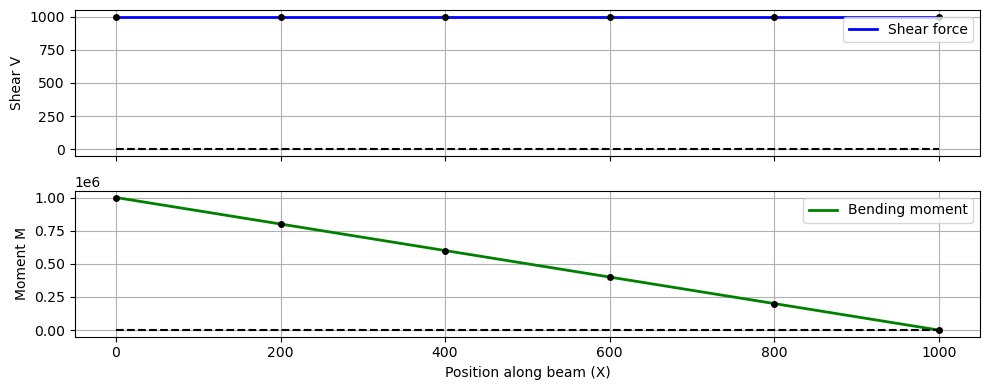

In [13]:
ft.postprocessing.plot_internal_actions_1D(fem_nodes, fem_elements, internal_actions, dof_per_node=2)


### Reaction components

In [14]:
# reaction components (see docs)
reactions, _ = ft.postprocessing.compute_reaction_forces(K_global, u, bc_nodes, bc_dofs, ndof_per_node)

DOF 0: Reaction force = 1000.00 N
DOF 1: Reaction force = 1000000.00 N


### Plots

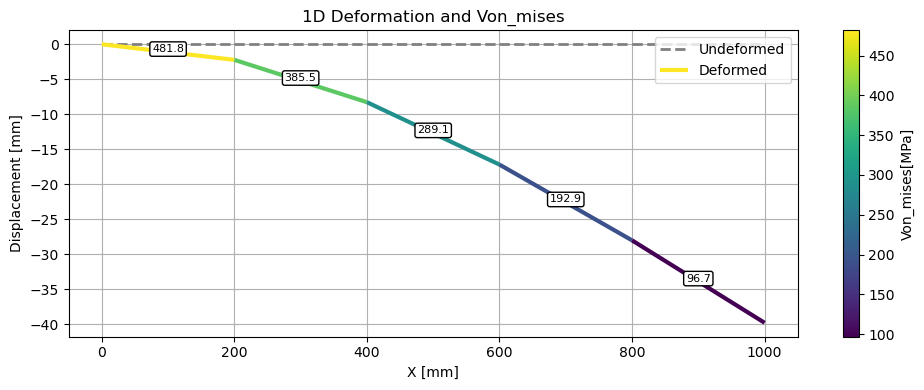

In [15]:
stress_type = "von_Mises"
ft.postprocessing.plot_1d_loaded_structure(fem_nodes, fem_elements, u, stresses[stress_type], stress_type=stress_type, ndof_per_node = ndof_per_node, scale=1, show_labels=True)

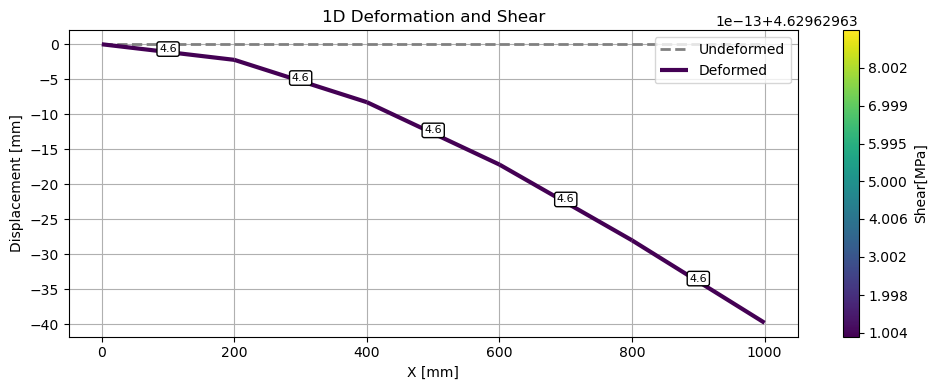

In [16]:
stress_type = "shear"
ft.postprocessing.plot_1d_loaded_structure(fem_nodes, fem_elements, u, stresses[stress_type], stress_type=stress_type, ndof_per_node = ndof_per_node, scale=1, show_labels=True)

### Animated plot for vibration modes

In [17]:
ft.postprocessing.animate_mode_shape_1D(mode_index=0, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_global, elements=fem_elements, ndof_per_node=2)

In [18]:

ft.postprocessing.animate_mode_shape_1D(mode_index=1, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_global, elements=fem_elements, ndof_per_node=2)